In [1]:
#Importem tot el necessari:
from pylab import *
from scipy.optimize import curve_fit
%matplotlib inline

## Input parameters:

In [2]:
#BACTERIA:
N = 100
v0 = 2 #um/s
lam = 1. #s^-1

#BOX (Square simulation box)
L = 400 #um 
#Discretisation for density computation
n = 512
dx = L/n #um 

# Time step in seconds
dt = 0.1 #s

#FEEDBACK PARAMETERS
tau = 0.1 #s
vfb = 20 #um/s


#displacement for the feedback
deltax = vfb*tau 

#parameters for the light dependent intensity
vmax=20.
k=0.5
vi=1.

#Light pattern for feedback:
u0=0.7
umin=0.
umax=4.

## Classes and methods

In [3]:
class Bacteria:

    def __init__(self, N, v0, lam):
        self.N = N
        self.v0 = v0
        self.lam = lam
        self.pos = zeros((2,N))
        self.vel = ones(N)*v0
        self.theta = random(N)*2*pi
        self.dir = array([cos(self.theta), sin(self.theta)])

    def distribute(self, L):
        self.pos = random((2,N))*L
        
    def distributemiddle(self, L):
        self.pos = random((2,N))*L/4+3*L/8
    
    def evolve(self,dt,light):
        self.v=setspeeds(light,self.pos)
        self.pos += dt*self.v*self.dir
        self.tumble(dt)
        self.boundary(L)
        
    def tumble(self, dt):
        r = random(self.N)
        cond = r<self.lam*dt
        ntumbles = count_nonzero(cond)
        theta = random(ntumbles)*2*pi
        self.theta[cond] = theta
        self.dir[:,cond] = array([cos(theta), sin(theta)])
        
    # PBC    
    def boundary(self, L):
        self.pos[self.pos>L]-=L
        self.pos[self.pos<0]+=L

        
class density:  
    def __init__(self, cells, n, dx):
        self.n = n
        self.dx=dx
        self.counts=zeros((self.n,self.n))    

    def snapshot(self,pos):      
        self.counts,bin_edges,bars=histogram2d(cells.pos[0], cells.pos[1], bins=(n,n),range=[[0, L], [0, L]])

        

def pattern(rho, deltax):
    row,column=where(rho>0.001)
    drow=deltax/dx

    light=ones((n,n))*u0

    indexx=((row-drow))
    indexxf=((row+drow))

    indexy=((column-drow))
    indexyf=((column+drow))

    indexx=around(indexx.astype(int))
    indexxf=around(indexxf.astype(int))
    indexy=around(indexy.astype(int))
    indexyf=around(indexyf.astype(int))

    points = size(indexx)

    for i in range(points):

        light[indexx[i]:row[i],indexy[i]:indexyf[i]]=umin
        light[row[i]:indexxf[i],indexy[i]:indexyf[i]]=umax


    return(light)

     

def setspeeds(light,pos):
    boxx=(pos[0]/dx).astype(int)
    boxy=(pos[1]/dx).astype(int)
    
    v=(vmax-vi)*light[boxx,boxy]/(k+light[boxx,boxy])+vi
    return(v)



### Speed dependence on light intensity

We model it as:
\begin{align}
v(u)=(v_{max}-v_i)\frac{u}{k+u}+v_i
\end{align}

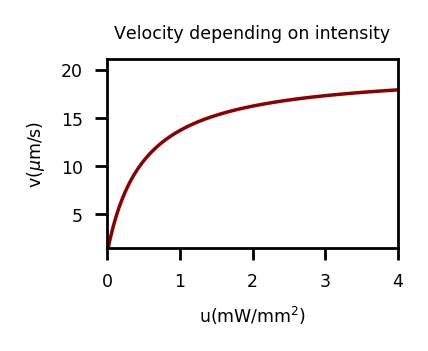

In [4]:
uu=linspace(0,4,100)
v=(vmax-vi)*uu/(k+uu)+vi

mysize=5
fig = plt.figure(figsize=(1.5,1),dpi=250)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=mysize)
plt.title( 'Velocity depending on intensity', fontsize=mysize)            
plt.xlabel('u(mW/mm$^2$)',fontsize=mysize)
plt.ylabel('v($\mu$m/s)',fontsize=mysize)
plt.xlim(right=umax,left=0)
plt.ylim(top=21.1,bottom=1.5)

plt.plot(uu,v,linewidth=1,color='darkred')

plt.show()


## Initial configuration

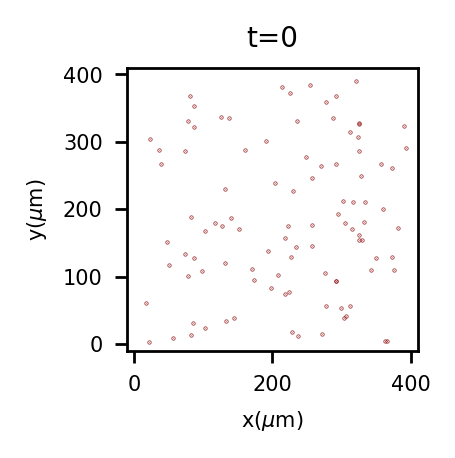

In [5]:
cells = Bacteria(N, v0, lam)
cells.distribute(L)

#-------------------------------------------------------------------------------
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1.5,1.5),dpi=250)
mysize=6
axes.set_title('t=0',fontsize=mysize+2)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)
axes.set_xlim(right=L+10,left=-10)
axes.set_ylim(top=L+10,bottom=-10)
#-------------------------------------------------------------------------------
axes.scatter(cells.pos[0],cells.pos[1],s=0.05, color='darkred', alpha=0.8)
plt.show()




### Evolve over steps

In [8]:
steps = 10000

resultsx=np.zeros([steps,N])
resultsy=np.zeros([steps,N])

resultsvx=np.zeros([steps,N])
resultsvy=np.zeros([steps,N])

for i in range(steps):
    dens=density(cells, n, dx)
    dens.snapshot(cells.pos)
    rho=dens.counts/(dx*dx)
    
    
    light = pattern(rho, deltax)
    
    cells.evolve(dt,light)
    
    resultsx[i,:]=cells.pos[0]
    resultsy[i,:]=cells.pos[1]
    
    resultsvx[i,:]=cells.v*cells.dir[0]
    resultsvy[i,:]=cells.v*cells.dir[1]

    print (i, end="\r")


## Average velocities:

In [9]:
print('vx=' + str(average(resultsvx))+ 'um/s')
print('vy=' + str(average(resultsvy))+ 'um/s')


vx=-0.13332230843498252um/s
vy=0.06477377141398284um/s


### Final configuration 

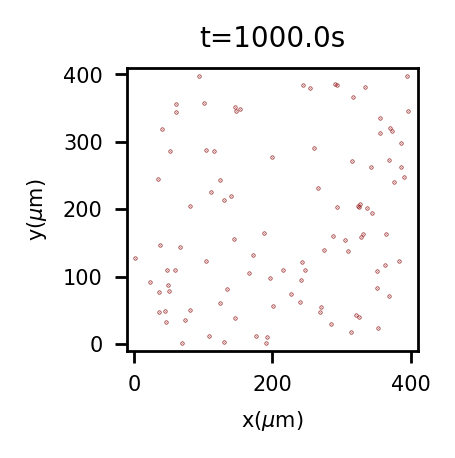

In [10]:
#-------------------------------------------------------------------------------
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1.5,1.5),dpi=250)
mysize=6
axes.set_title('t=' + str(steps*dt) + 's',fontsize=mysize+2)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)
axes.set_xlim(right=L+10,left=-10)
axes.set_ylim(top=L+10,bottom=-10)
#-------------------------------------------------------------------------------
axes.scatter(cells.pos[0],cells.pos[1],s=0.05, color='darkred', alpha=0.8)
plt.show()

# Animation

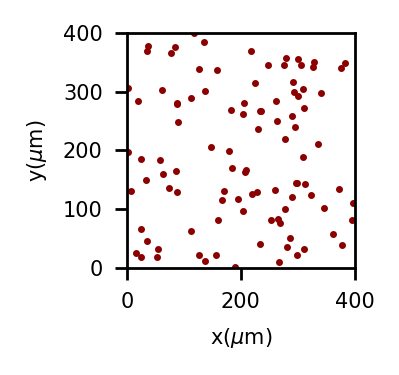

In [9]:
from matplotlib import animation
from IPython.display import HTML

fr_ps=np.int(1./dt)

# Speed up the video:
speed=1. 

fig = plt.figure(figsize=(1.7,1.6),dpi=250)
ax = plt.axes(xlim=(0, L), ylim=(0, L)) 
scat = ax.scatter([], [], s=1, color='darkred')

line, = ax.plot([], [], lw=2) 

#plt.title( 'Particles with $v_0$=' + str(v0) + ' $\mu$m/s, a probability of tumbling \n'
#            '$P_t=$' + str(p_s) + ' $s^{-1}$ (video speed ' + str(speed) + 'x)', fontsize=mysize)            
plt.xlabel('x($\mu$m)',fontsize=mysize)
plt.ylabel('y($\mu$m)',fontsize=mysize)
ax.tick_params(labelsize=mysize)
plt.tight_layout()


def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    return line, 


transpxy=np.transpose([resultsx, resultsy])

# animation function 
def animate(i): 
    scat.set_offsets(transpxy[:,i])
    print (i, end="\r")

    return scat, 

    
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                        frames=steps, interval=100/speed, blit=True) 

HTML(anim.to_html5_video())

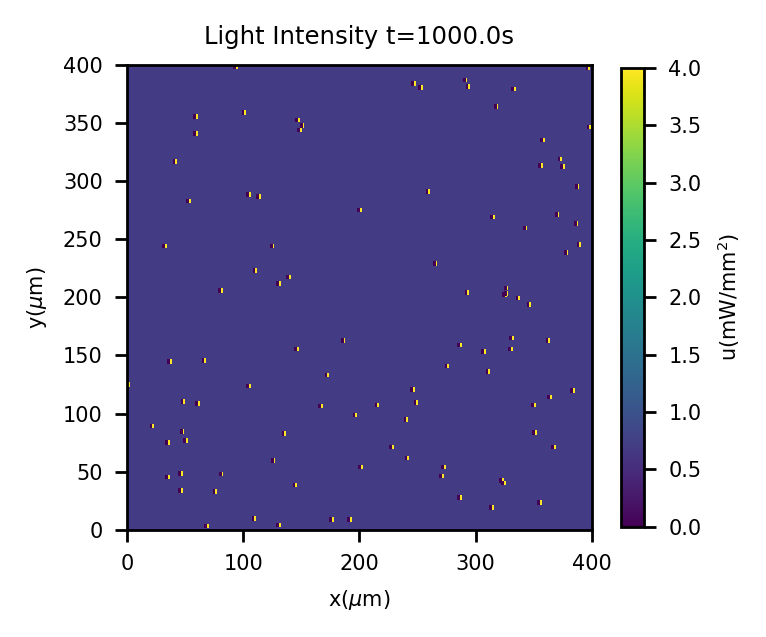

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3,3),dpi=250)
mysize=6
axes.set_title('Light Intensity t=' + str(steps*dt) + 's',fontsize=mysize+1)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)

imshow(transpose(light), origin='lower',extent=[0,L,0,L],cmap='viridis')

cbar=colorbar(shrink=0.81)
cbar.set_label(label='u(mW/mm$^2$)', size=mysize)
cbar.ax.tick_params(labelsize=mysize)

plt.show()

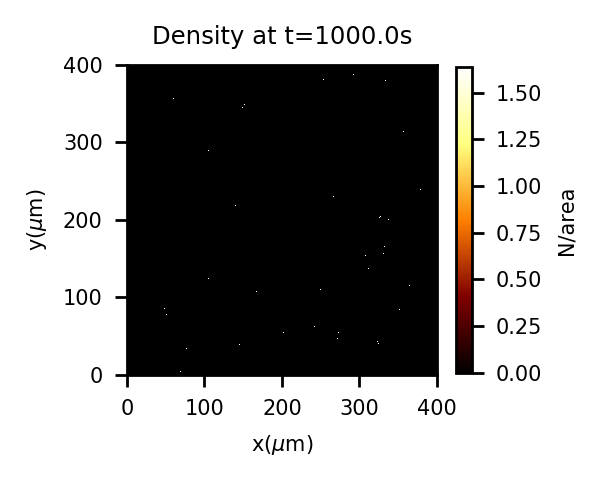

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2,2),dpi=250)
mysize=6
axes.set_title('Density at t=' + str(steps*dt) + 's',fontsize=mysize+1)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)

imshow(transpose(rho), origin='lower',cmap='afmhot',extent=[0,L,0,L])

cbar=colorbar(shrink=0.81)
cbar.set_label(label='N/area', size=mysize)
cbar.ax.tick_params(labelsize=mysize)

### We change the initial state and put all the bacteria in the center

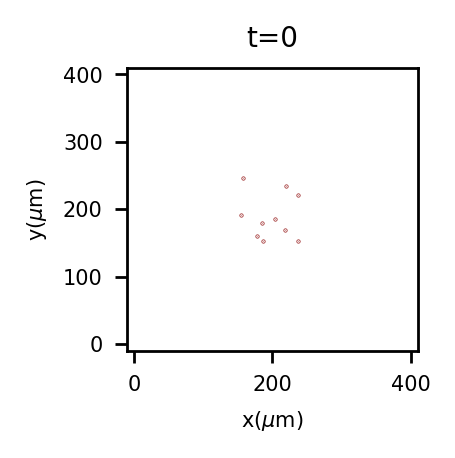

In [13]:
N=10
cells = Bacteria(N, v0, lam)
cells.distributemiddle(L)

#-------------------------------------------------------------------------------
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1.5,1.5),dpi=250)
mysize=6
axes.set_title('t=0',fontsize=mysize+2)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)
axes.set_xlim(right=L+10,left=-10)
axes.set_ylim(top=L+10,bottom=-10)
#-------------------------------------------------------------------------------
axes.scatter(cells.pos[0],cells.pos[1],s=0.05, color='darkred', alpha=0.8)
plt.show()

### Evolve over steps

In [14]:
steps = 500

resultsx=np.zeros([steps,N])
resultsy=np.zeros([steps,N])


for i in range(steps):
    dens=density(cells, n, dx)
    dens.snapshot(cells.pos)
    rho=dens.counts/(dx*dx)
    
    light = pattern(rho, deltax)
    
    cells.evolve(dt,light)
    
    resultsx[i,:]=cells.pos[0]
    resultsy[i,:]=cells.pos[1]
    
    print (i, end="\r")

### Final configuration 

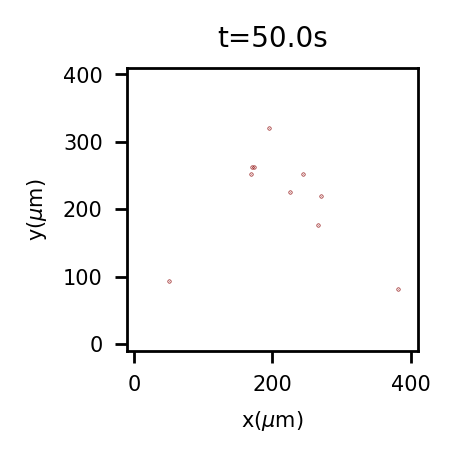

In [15]:
#-------------------------------------------------------------------------------
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1.5,1.5),dpi=250)
mysize=6
axes.set_title('t=' + str(steps*dt) + 's',fontsize=mysize+2)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)
axes.set_xlim(right=L+10,left=-10)
axes.set_ylim(top=L+10,bottom=-10)
#-------------------------------------------------------------------------------
axes.scatter(cells.pos[0],cells.pos[1],s=0.05, color='darkred', alpha=0.8)
plt.show()

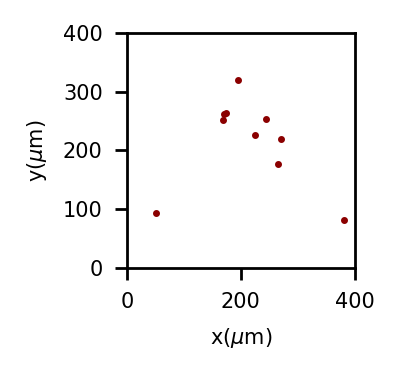

In [16]:
from matplotlib import animation
from IPython.display import HTML

fr_ps=np.int(1./dt)

# Speed up the video:
speed=1. 

fig = plt.figure(figsize=(1.7,1.6),dpi=250)
ax = plt.axes(xlim=(0, L), ylim=(0, L)) 
scat = ax.scatter([], [], s=1, color='darkred')

line, = ax.plot([], [], lw=2) 

#plt.title( 'Particles with $v_0$=' + str(v0) + ' $\mu$m/s, a probability of tumbling \n'
#            '$P_t=$' + str(p_s) + ' $s^{-1}$ (video speed ' + str(speed) + 'x)', fontsize=mysize)            
plt.xlabel('x($\mu$m)',fontsize=mysize)
plt.ylabel('y($\mu$m)',fontsize=mysize)
ax.tick_params(labelsize=mysize)
plt.tight_layout()


def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    return line, 


transpxy=np.transpose([resultsx, resultsy])

# animation function 
def animate(i): 
    scat.set_offsets(transpxy[:,i])
    print (i, end="\r")

    return scat, 

    
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                        frames=steps, interval=100/speed, blit=True) 

HTML(anim.to_html5_video())

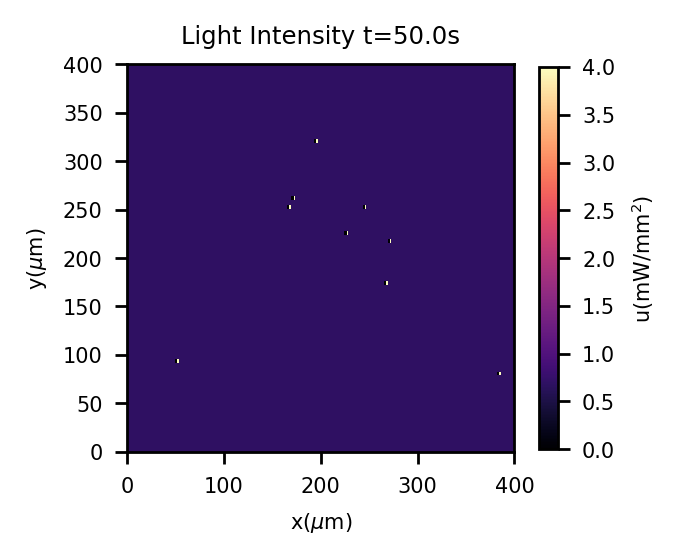

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2.5,2.5),dpi=250)
mysize=6
axes.set_title('Light Intensity t=' + str(steps*dt) + 's',fontsize=mysize+1)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)

imshow(transpose(light), origin='lower',extent=[0,L,0,L],cmap='magma')

cbar=colorbar(shrink=0.81)
cbar.set_label(label='u(mW/mm$^2$)', size=mysize)
cbar.ax.tick_params(labelsize=mysize)

plt.show()

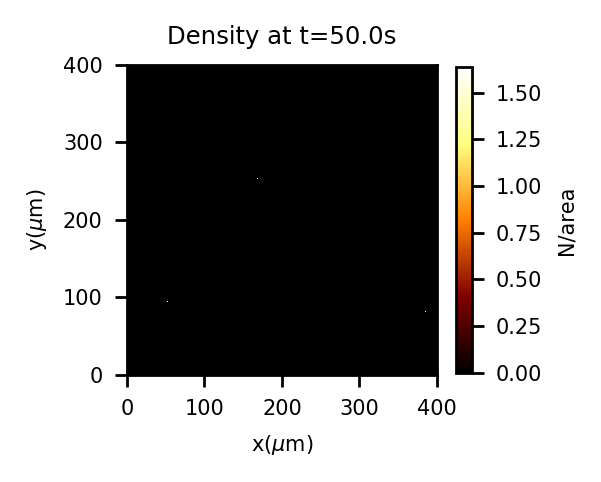

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2,2),dpi=250)
mysize=6
axes.set_title('Density at t=' + str(steps*dt) + 's',fontsize=mysize+1)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)

imshow(transpose(rho), origin='lower',cmap='afmhot',extent=[0,L,0,L])

cbar=colorbar(shrink=0.81)
cbar.set_label(label='N/area', size=mysize)
cbar.ax.tick_params(labelsize=mysize)